In [1]:
%matplotlib widget
import rebound
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
from matplotlib.collections import LineCollection

# Change parameters here

In [2]:
mu=3e-6          # m_1/m_star
j, k = 10, 1     # j:j-k MMR
pomega = np.pi/2 # pericenter of outer test particle
phi = 2*np.pi/3  # Angle of conjunction relative to pericenter (resonant angle)

n = 2*np.pi
n20 = n*(j-k)/j
deltan = 0.0

n2_init = n20 + deltan
deltan0 = n-n20
ec = 2*k/3/j
etilde = 0.3
e = etilde*ec
deltat = 2/3/n20 # time to move delta a in y at a rate delta v

In [3]:
def setup(t0=-deltat, theta=None): # make sim with sim.t = t0 (where conjunction always happens near t=0, use get_conjunction_time to get exact)
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1)
    sim.add(m=mu, P=1, 
            l=pomega+phi+n*t0) # phi = l - pomega, so l = pomega+phi
    ps = sim.particles
    if theta is None:
        theta = pomega+phi+(n20+deltan)*t0
    sim.add(P=2*np.pi/(n2_init), e=etilde*ec, pomega=pomega, l=theta) # use f instead of lambda to be exact loc
    sim.t = t0
    return sim

def get_conjunction_time(t0=-deltat): # 
    tconj = 0
    for i in range(5):
        sim = setup(-deltat)
        sim.integrate(tconj)
        ps = sim.particles
        corr = (ps[2].theta-ps[1].theta)/(n-(n20+deltan))
        print(corr)
        tconj += corr
    return tconj

interactive(children=(FloatSlider(value=-1.0, description='t', max=1.0, min=-1.0, step=0.02), Output()), _dom_…

<function __main__.run(t)>

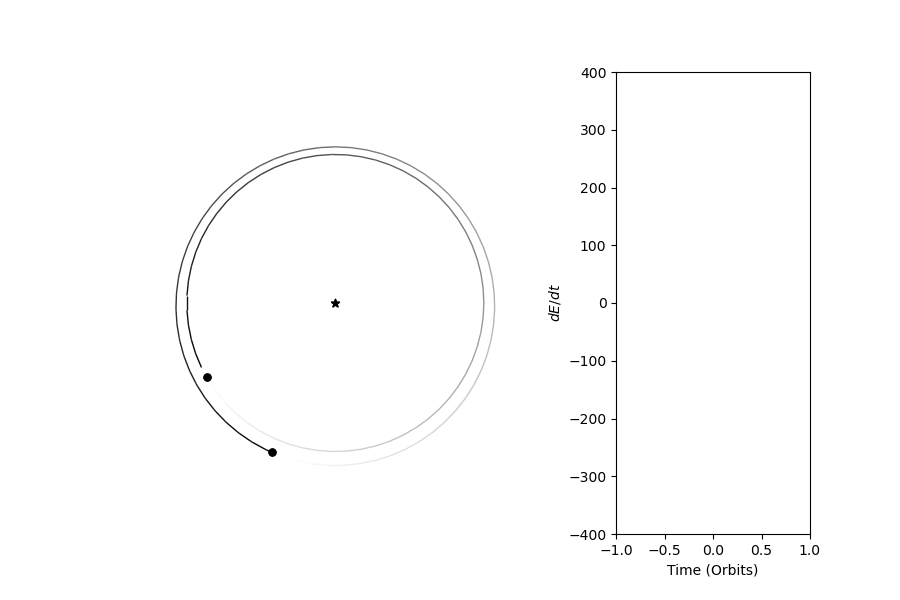

In [4]:
from ipywidgets import interact, FloatSlider
from matplotlib.gridspec import GridSpec

def run(t):
    global ctr
    for ctr in range(ctr, 1000):
        if times[ctr] > t:
            break
        op.sim.integrate(times[ctr])
        dx = ps[2].x-ps[1].x
        dy = ps[2].y-ps[1].y
        Edot[ctr] = -(dx*ps[2].vx + dy*ps[2].vy)/(dx**2 + dy**2)**(3/2)
        ctr += 1
    line1.set_ydata(Edot)
    op.update()
    op.fig.canvas.draw()
    op.fig.canvas.flush_events()
    
tmin=-1
tmax=1
sim = setup(t0=tmin)
ps = sim.particles
fig = plt.figure(figsize=(9,6))
gs = GridSpec(1,3)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2])
op = rebound.OrbitPlot(sim, fig=fig, ax=ax1)
op.ax.set_xlim([-1.5,1.5])
op.ax.set_ylim([-1.5,1.5])
op.ax.set_aspect('equal')
op.ax.axis('off')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-400, 400])
ax2.set_xlabel('Time (Orbits)')
ax2.set_ylabel('$dE/dt$')
times = np.linspace(-1, 1, 1000)
Edot = np.zeros(1000)*np.nan
line1, = ax2.plot(times, Edot)
ctr = 0
plt.subplots_adjust(wspace=0.3)
interact(run, t=FloatSlider(value=tmin, min=tmin, max=tmax, step=(tmax-tmin)/100))

# As you change parameters you will have to change hardcoded axes limits

interactive(children=(IntSlider(value=0, description='Nconj', max=300), Output()), _dom_classes=('widget-inter…

<function __main__.runconj(Nconj)>

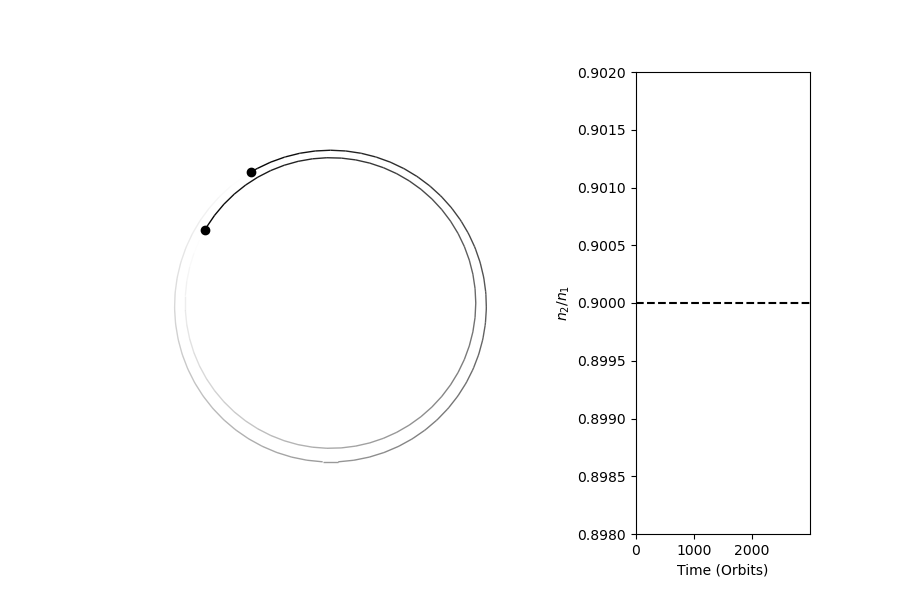

In [5]:
def update():
    for i in [1,2]:
        pts = np.array(ps[i].sample_orbit(Npts=Narc+1))
        theta = ps[2].pomega-np.pi/2
        R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
        x,y = np.matmul(R, pts[:,:2].T)
        
        segments = np.zeros((Narc,2,2))
        segments[:,0,0] = x[:-1]
        segments[:,0,1] = y[:-1]
        segments[:,1,0] = x[1:]
        segments[:,1,1] = y[1:]
        orbits[i-1].set_segments(segments)

def update_orbits(conj=True):
    theta = ps[2].pomega-np.pi/2
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    x2,y2 = np.matmul(R, [[ps[2].x], [ps[2].y]])
    x1,y1 = np.matmul(R, [[ps[1].x], [ps[1].y]])
    s.set_offsets([[x1,y1], [x2,y2]])
    
    if conj == True:
        if x2 > 0:
            line2.set_color('b')
        else:
            line2.set_color('r')
        line2.set_xdata([0, x2])
        line2.set_ydata([0, y2])
    
def runconj(Nconj):
    global ctr
    if Nconj == 0:
        update_orbits(conj=False)
        update()
        return
    deltatheta = np.sin(ps[1].theta - ps[2].theta)
    searchtimes = np.linspace(sim.t, sim.t+ps[1].P*j/k, Nsearch)
    for i, time in enumerate(searchtimes):
        sim.integrate(time)
        nratio[ctr+i] = ps[2].n/ps[1].n
        prevdeltatheta = deltatheta
        deltatheta = np.sin(ps[1].theta - ps[2].theta)
        if prevdeltatheta < 0 and deltatheta > 0:
            update_orbits()
            update()
            Nconj += 1
    line1.set_ydata(nratio)  
    lasttime = times[~np.isnan(nratio)][-1]
    ax2.set_xlim([times[0], lasttime+10])
    fig.canvas.draw()
    fig.canvas.flush_events()
    ctr += Nsearch
    
Nmax=300
fig = plt.figure(figsize=(9,6))
gs = GridSpec(1,3)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2])
ax2.set_ylim([(j-k)/j-0.002, (j-k)/j+0.002])

Nsearch=1000
Narc=128
tconj=j/k # ps[1].P = 1
tmin=-tconj/6
tmax=tmin+tconj*Nmax
sim = setup(t0=-tmin/2)
ps = sim.particles
orbits = []
for i in [1,2]:
    lc = LineCollection([], lw=1)
    line_colors = np.zeros((Narc+1, 4))
    line_colors[:,3] = np.linspace(0, 1, Narc+1)
    lc.set_color(line_colors)
    orbits.append(lc)
    ax1.add_collection(lc)

ax1.set_xlim([-1.5,1.5])
ax1.set_ylim([-1.5,1.5])
ax1.set_aspect('equal')
ax1.axis('off')
ax2.set_xlim([tmin, tmax])
ax2.axhline((j-k)/j, color='k', linestyle='--')
ax2.set_xlabel('Time (Orbits)')
ax2.set_ylabel(r'$n_2/n_1$')
times = np.linspace(tmin, tmax, Nmax*Nsearch)
nratio = np.zeros(Nmax*Nsearch)*np.nan
line1, = ax2.plot(times, nratio)
line2, = ax1.plot([0, np.nan], [0, np.nan], 'r--')
s = ax1.scatter([np.nan, np.nan], [np.nan, np.nan], color='k')
ctr = 0
plt.subplots_adjust(wspace=0.5)
interact(runconj, Nconj=IntSlider(value=0, min=0, max=Nmax))